## Resource-Constrained Project Scheduling with Blocking Times No-Preemption

### Problem Definiton

Tasks have flexible execution windows (preemption allowed based on availability) but strict finish-to-start precedence constraints. Each task requires specific quantities of resources from disjoint candidate sets. Unlike standard duration-based scheduling, tasks here are defined by size, allowing them to split across resource breaks (e.g., weekends) automatically. Formally, the problem is defined as follows: Let $\mathcal{N}=\{1,\ldots,N\}$ be a set of tasks. Let $S\in\mathbb{N}^{|\mathcal{N}|}$ be a vector of task sizes (total effort required). Let $\mathcal{E}$ be a set of precedences. Let $\mathcal{R}=\{1,\ldots,M\}$ be a set of resources. Let $\bar{u}_r(t): \mathbb{N} \to \{0,1\}$ be the availability function (intensity) of resource $r$. For each task $i$, let $\mathcal{K}_i$ be resource requirement indices, where each requirement has a candidate set $\mathcal{C}_{i,k}$ and a quantity $Q_{i,k}$.

### CP Optimizer Formulation

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
\qquad & \forall (i, j) \in \mathcal{E}
\quad & \text{(2)} \\[2mm]
& \sum_{r \in \mathcal{C}_{i,k}} \operatorname{presenceOf}(A_{i,r}) = Q_{i,k},
\qquad & \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i
\quad & \text{(3)} \\[2mm]
& \operatorname{startAtStart}(T_i, A_{i,r}) \land \operatorname{endAtEnd}(T_i, A_{i,r}),
\qquad & \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i, \forall r \in \mathcal{C}_{i,k}
\quad & \text{(4)} \\[2mm]
& \operatorname{noOverlap}(\{A_{i,r} \mid i \in \mathcal{N} \text{ s.t. } r \in \bigcup \mathcal{C}\}),
\qquad & \forall r \in \mathcal{R}
\quad & \text{(5)} \\[2mm]
& \operatorname{sizeOf}(A_{i,r}) = \int_{\operatorname{start}(A_{i,r})}^{\operatorname{end}(A_{i,r})} \mathcal{F}_r(t) \, dt,
\qquad & \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i, \forall r \in \mathcal{C}_{i,k}
\quad & \text{(6)} \\[2mm]
& \mathcal{F}_r = \operatorname{CpoStepFunction}(\text{steps}=\{(t_0, v_0), \dots, (t_m, v_m)\}),
\qquad & \forall r \in \mathcal{R}
\quad & \text{(7)} \\[2mm]
& T_i: \text{mandatory interval var }
\qquad & \forall i \in \mathcal{N}
\quad & \text{(8a)} \\[1mm]
& A_{i,r}: \text{optional interval var}, \text{ intensity } \mathcal{F}_r,
\qquad & \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i, \forall r \in \mathcal{C}_{i,k}
\quad & \text{(8b)}
\end{aligned}
$$

Objective
* **(1)** Minimize Makespan: The goal is to minimize the end time of the latest completing task in the project.

Modeling Constraints
* **(2)** Precedence Relations: Enforces strictly that task $j$ cannot start until task $i$ has finished.
* **(3)** Multi-Resource Quantity Assignment: Ensures that for every requirement $k$ of task $i$, exactly $Q_{i,k}$ resources are selected from the candidate set $\mathcal{C}_{i,k}$.
* **(4)** Temporal Synchronization: Enforces that if a resource $r$ is selected (assigned) to a task, it must execute exactly parallel to the master task interval $T_i$ (same Start and End).
* **(5)** Resource Capacity: The `noOverlap` constraint ensures that a specific resource $r$ processes at most one task at a time.
* **(6)** Intensity Integration: Mathematically links the Size of the assignment to the integral of the efficiency function $\mathcal{F}_r$. This implies that if $\mathcal{F}_r(t)=0$, the interval must elongate to accumulate the required Size $S_i$.

Variable and Function Definitions
* **(7)** $\mathcal{F}_r$: A `CpoStepFunction` object representing the efficiency of resource $r$. It is defined by a list of steps `(x, val)` indicating the value of the function starting at time `x`.
* **(8a)** $T_i$: A mandatory interval variable representing the execution of task $i$.
* **(8b)** $A_{i,r}$: An optional interval variable representing the assignment of task $i$ to resource $r$. It is defined by Size $S_i$ and is explicitly linked to the intensity function $\mathcal{F}_r$.

Parameters (Input Data)
* $\mathcal{N}$: The set of tasks.
* $\mathcal{E}$: The set of precedence relations.
* $\mathcal{R}$: The set of discrete resources.
* $S_i$: The fixed Size (effort in man-hours/machine-hours) of task $i$.
* $steps$: The list of tuples $(t, v)$ defining the availability calendar for each resource.
* $\mathcal{K}_i$: The set of requirement indices for task $i$ (e.g., $\{1, 2\}$ if a task needs both a type 1 and a type 2 resource).
* $\mathcal{C}_{i,k}$: The disjoint set of candidate resources for requirement $k$ of task $i$.
* $Q_{i,k}$: The quantity of resources required from set $\mathcal{C}_{i,k}$.

### DOCPLEX Implementation

#### Imports

In [1]:
from docplex.cp.model import *
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
from collections import defaultdict

#### Parsing the data file

In [2]:
def next_line(f):
    """Read next non-empty, non-comment line"""
    line = None
    while not line:
        raw = f.readline()
        if not raw:
            return None
        line = raw.strip()
        if line.startswith('#'):
            line = None
    return [int(v) for v in line.split()]

In [3]:
filename = "../data/rcpspblocking/00.data"

with open(filename, "r") as f:
    N, M = next_line(f)
    TASKS = []
    for _ in range(N):
        task_data = next_line(f)
        task_id = task_data[0]
        size = task_data[1]
        num_reqs = task_data[2]
        
        requirements = []
        idx = 3
        for _ in range(num_reqs):
            num_candidates = task_data[idx]
            quantity = task_data[idx + 1]
            candidates = task_data[idx + 2:idx + 2 + num_candidates]
            requirements.append((num_candidates, quantity, candidates))
            idx += 2 + num_candidates
        TASKS.append((task_id, size, num_reqs, requirements))
    RESOURCES = []
    for _ in range(M):
        res_data = next_line(f)
        res_id = res_data[0]
        num_steps = res_data[1]
        steps = [(res_data[2 + 2*i], res_data[2 + 2*i + 1]) for i in range(num_steps)]
        RESOURCES.append((res_id, steps))
    prec_data = next_line(f)
    num_prec = prec_data[0]
    PRECEDENCES = [(prec_data[1 + 2*i], prec_data[1 + 2*i + 1]) for i in range(num_prec)]

#### Prepare data structures

In [4]:
S = {t[0]: t[1] for t in TASKS}
K = {t[0]: list(range(t[2])) for t in TASKS}
C = {(t[0], k): req[2] for t in TASKS for k, req in enumerate(t[3])}
Q = {(t[0], k): req[1] for t in TASKS for k, req in enumerate(t[3])}
E = PRECEDENCES
F = {}
for res_id, steps in RESOURCES:
    F[res_id] = CpoStepFunction(steps=steps)

In [5]:
print(f"\n{'='*70}\nINSTANCE: {N} tasks, {M} resources, {len(PRECEDENCES)} precedences\n{'='*70}")
print("\nTASKS:")
for tid, size, num_reqs, reqs in TASKS:
    if size == 0:
        print(f"  T{tid}: size={size:2d}  DUMMY")
    else:
        req_strs = []
        for req_idx, (num_cands, qty, *cand_ids) in enumerate(reqs):
            if qty > 0:
                candidates = '{' + ','.join(f'R{r}' for r in cand_ids) + '}'
                req_strs.append(f"{qty} from {candidates}")
        if req_strs:
            print(f"  T{tid}: size={size:2d}  needs: {' AND '.join(req_strs)}")
        else:
            print(f"  T{tid}: size={size:2d}  needs: nothing")
print("\nRESOURCES:")
for rid, steps in RESOURCES:
    windows = [f"{steps[i][0]}-{steps[i+1][0]}" for i in range(len(steps)-1) if steps[i][1] > 0]
    if windows:
        print(f"  R{rid}: available {', '.join(windows)}")
    else:
        print(f"  R{rid}: never available")
print("\nPRECEDENCES:")
if PRECEDENCES:
    prec = defaultdict(list)
    for p, s in PRECEDENCES: 
        prec[p].append(s)
    for p in sorted(prec): 
        print(f"  T{p} → {', '.join(f'T{s}' for s in sorted(prec[p]))}")
else:
    print("  (none)")
print("="*70)


INSTANCE: 4 tasks, 2 resources, 5 precedences

TASKS:
  T0: size= 0  DUMMY
  T1: size= 4  needs: 1 from {R[0, 1]}
  T2: size= 2  needs: 2 from {R[0, 1]}
  T3: size= 0  DUMMY

RESOURCES:
  R0: available 0-2, 4-9
  R1: available 2-4, 6-7

PRECEDENCES:
  T0 → T1, T2
  T1 → T2, T3
  T2 → T3


#### Create model and variables

In [6]:
mdl = CpoModel()

# (8a) T_i: mandatory interval variables WITHOUT fixed size
# The size is implicitly determined by the synchronized assignments
T = {i: interval_var(name=f"T_{i}") for i in range(N)}

# (8b) A_{i,r}: optional interval variables with size and intensity
A = {}
for i in range(N):
    for k in K[i]:
        for r in C[(i, k)]:
            A[(i, r)] = interval_var(
                size=S[i],
                intensity=F[r],
                optional=True,
                name=f"A_{i}_{r}\n"
            )

#### Add constraints and define objective

In [7]:
# (1) Minimize makespan
mdl.add(minimize(max([end_of(T[i]) for i in range(N)])))

In [8]:
# (2) Precedence constraints
for (i, j) in E:
    mdl.add(end_before_start(T[i], T[j]))

# (3) Multi-resource quantity assignment
for i in range(N):
    for k in K[i]:
        mdl.add(sum(presence_of(A[(i, r)])
                for r in C[(i, k)] if (i, r) in A) == Q[(i, k)])

# (4) Temporal synchronization
for i in range(N):
    for k in K[i]:
        for r in C[(i, k)]:
            if (i, r) in A:
                mdl.add(start_at_start(T[i], A[(i, r)]))
                mdl.add(end_at_end(T[i], A[(i, r)]))

# (5) Resource capacity - no overlap for each resource
for r in range(M):
    assignments = [A[(i, r)] for i in range(N) if (i, r) in A]
    if assignments:
        mdl.add(no_overlap(assignments))

#### Solve the model

In [9]:
print("Solving...")
res = mdl.solve(LogVerbosity='Quiet')

Solving...


In [10]:
if res:
    print(f"\nSolution found!")
    print(f"Makespan: {res.get_objective_values()[0]}")
    print(f"Solve time: {res.get_solve_time():.2f} seconds\n")
    for i in range(N):
        t_sol = res.get_var_solution(T[i])
        if t_sol is None:
            print(f"Task T{i}: No solution found")
            continue 
        task_start = t_sol.get_start()
        task_end = t_sol.get_end()
        task_size = S[i]
        task_duration = task_end - task_start
        task_blocked = task_duration - task_size
        print(f"Task T{i}: Start={task_start}, End={task_end}, Size={task_size}, Duration={task_duration}, Blocked={task_blocked}")
        for (task_id, r) in A:
            if task_id == i:
                a_sol = res.get_var_solution(A[(task_id, r)])
                if a_sol is not None and a_sol.is_present():
                    r_start = a_sol.get_start()
                    r_end = a_sol.get_end()
                    r_size = a_sol.get_size()
                    r_duration = r_end - r_start
                    r_blocked = r_duration - r_size
                    print(f"  └─ R{r}: Working [{r_start}→{r_end}], Work time={r_size}, Blocked time={r_blocked}")
        print()
else:
    print("No solution found within time limit")


Solution found!
Makespan: 10
Solve time: 0.02 seconds

Task T0: Start=0, End=0, Size=0, Duration=0, Blocked=0

Task T1: Start=0, End=6, Size=4, Duration=6, Blocked=2
  └─ R0: Working [0→6], Work time=4, Blocked time=2

Task T2: Start=7, End=10, Size=2, Duration=3, Blocked=1
  └─ R0: Working [7→10], Work time=2, Blocked time=1
  └─ R1: Working [7→10], Work time=2, Blocked time=1

Task T3: Start=10, End=10, Size=0, Duration=0, Blocked=0



#### Visualisation

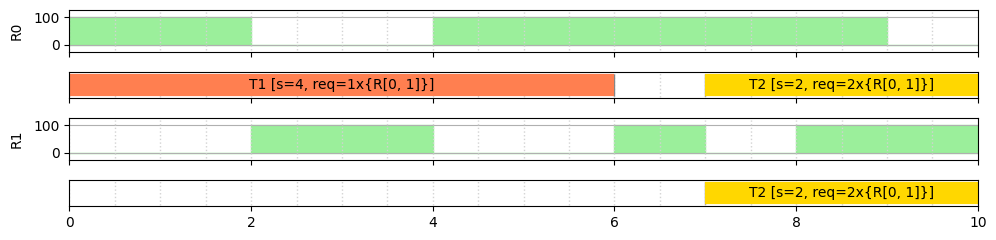

In [11]:
if res and visu.is_visu_enabled():
    plt.rcParams["figure.figsize"] = (10, 2.5)
    task_colors = ['steelblue', 'coral', 'gold', 'mediumpurple', 'darkcyan', 'sandybrown']
    task_labels = {}
    for tid, size, num_reqs, reqs in TASKS:
        req_strs = []
        for num_cands, qty, *cand_ids in reqs:
            if qty > 0:
                candidates = '{' + ','.join(f'R{r}' for r in cand_ids) + '}'
                req_strs.append(f"{qty}x{candidates}")
        req_text = ', '.join(req_strs) if req_strs else 'none'
        task_labels[tid] = f'T{tid} [s={size}, req={req_text}]'
    for r in range(len(F)):
        visu.panel(f'R{r}')
        visu.function(segments=F[r], style='area', color='lightgreen')
        for (task_id, res_id) in A:
            if res_id == r:
                a_sol = res.get_var_solution(A[(task_id, res_id)])
                if a_sol and a_sol.is_present():
                    visu.interval(a_sol, task_colors[task_id % len(task_colors)], task_labels[task_id])
    visu.show()

## Aditional Resources

#### [ForbidExtent()](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.forbid_extent) vs [Stepwise Functions](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.function.py.html#docplex.cp.function.CpoStepFunction)

A. Stepwise Function (`CpoStepFunction`)
* **Type:** Data Structure (Passive).
* **Definition:** A function $f(t)$ that defines values over time.
* **Role:** It acts as a **Map**. It describes the environment (e.g., "The machine is broken from 10:00 to 12:00").
* **Effect:** On its own, it does **nothing** to the schedule. It just holds information.

B. Forbid Extent (`forbid_extent`)
* **Type:** Constraint (Active).
* **Definition:** A rule applied to the model.
* **Role:** It acts as the **Enforcer**. It looks at a Stepwise Function and applies a restriction.
* **Effect:** It forces the solver to ensure a task **never overlaps** with any time segment where the Stepwise Function has a value of `0`.

[ICAPS 2017: Video Tutorial – Philippe Laborie: Introduction to CP Optimizer for Scheduling](https://www.youtube.com/watch?v=-VY7QTnSAio), [Slides from the video](https://icaps17.icaps-conference.org/tutorials/T3-Introduction-to-CP-Optimizer-for-Scheduling.pdf)

slide 42: interval variable size, length adn intensity funciton

what for? 
- modeling cases where the intensity of work is not the same duting the whole interval and the interval requires some quantity of work to be done before completion

- activities that are suspended during some time periods (e.g. week-end, vacation)

- https://www.ibm.com/docs/en/icos/22.1.2?topic=scheduling-interval-variables

How to model that?

- Stretch tasks across closed periods (simple “calendar” via intensity)
- When to use: Tasks are not preemptable and simply “pause” during closed time (e.g., a 6-hour job that starts at 10:00 spans over a 12:00–13:00 lunch and finishes at 17:00).

Make each task’s processing requirement the size.

Give tasks an intensity step function that is 100 when working and 0 when blocked.
CP Optimizer will automatically lengthen the interval to cover the size only during periods with intensity > 0.

In [12]:
mdl = CpoModel()

# Example data
jobs = ["A", "B"]
durations = {"A": 6, "B": 4}  # required work time in "work units" (e.g. hours)

# Define a step function for working hours
# open 8:00–12:00, 13:00–17:00 (minutes since midnight)
work_cal = CpoStepFunction()
work_cal.set_value(0, 8*60, 0)      # before 8:00 off
work_cal.set_value(8*60, 12*60, 100)
work_cal.set_value(12*60, 13*60, 0)
work_cal.set_value(13*60, 17*60, 100)
work_cal.set_value(17*60, 24*60, 0)

# Create interval variables with that intensity
tasks = {j: mdl.interval_var(size=durations[j], intensity=work_cal, name=j)
         for j in jobs}

# Single machine
mdl.add(mdl.no_overlap(list(tasks.values())))

# Example objective (minimize makespan)
mdl.add(mdl.minimize(mdl.max([mdl.end_of(t) for t in tasks.values()])))


Forbid any overlap with closed periods (forbidExtent)

When to use: You want to prohibit a task from covering any closed time at all (it must sit entirely inside open windows).

 - Build a “closed” step function that is 1 during blocked time and 0 otherwise.

- Use forbidExtent so [start, end) of each interval never intersects a blocked segment.

In [13]:
mdl = CpoModel()

jobs = ["A", "B"]
durations = {"A": 6, "B": 4}

# Define a "closed" step function: 1 during blocked periods, 0 otherwise
closed = CpoStepFunction()
closed.set_value(0, 8*60, 1)
closed.set_value(8*60, 12*60, 0)
closed.set_value(12*60, 13*60, 1)
closed.set_value(13*60, 17*60, 0)
closed.set_value(17*60, 24*60, 1)

tasks = {j: mdl.interval_var(size=durations[j], name=j) for j in jobs}

# Forbid tasks from overlapping blocked times
for j in jobs:
    mdl.add(mdl.forbid_extent(tasks[j], closed))

mdl.add(mdl.no_overlap(list(tasks.values())))
mdl.add(mdl.minimize(mdl.max([mdl.end_of(t) for t in tasks.values()])))


Insert downtime as fixed intervals and share the resource (noOverlap with extra intervals)

When to use: You want downtime to consume the same resource just like a job (e.g., planned maintenance blocks the machine).

- Create fixed, present interval variables for each blocking window.

- Put both jobs and downtime intervals into the same noOverlap.

In [14]:
mdl = CpoModel()

jobs = ["A", "B"]
durations = {"A": 6, "B": 4}

# Known downtime intervals (start, end)
downtimes = [(12*60, 13*60)]  # 12:00–13:00

tasks = {j: mdl.interval_var(size=durations[j], name=j) for j in jobs}

# Create fixed blocking intervals
blocks = []
for i, (s, e) in enumerate(downtimes):
    iv = mdl.interval_var(start=s, end=e, name=f"block_{i}")
    mdl.add(mdl.presence_of(iv) == 1)
    blocks.append(iv)

# Combine jobs + blocks in same machine constraint
mdl.add(mdl.no_overlap(list(tasks.values()) + blocks))

mdl.add(mdl.minimize(mdl.max([mdl.end_of(t) for t in tasks.values()])))

forbidStart(), forbidEnd(), forbidExtent()